In [1]:
import pandas as pd
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from scipy.cluster.hierarchy import dendrogram, linkage

import scikitplot as skp

%matplotlib inline

In [2]:
# read the pickled data
pickle_data = open(os.path.join(os.getcwd(), '..', 'data', 'processed', 'clean_data.pickle'), 'rb')
data = pickle.load(pickle_data)
# rename the columns for plotting
data.columns = ['Year', 'Income Index', 'Education Index', 'Percent White',
                'Rent Index', 'Value Index', 'Percent Employed']

In [3]:
# first column is year, which I don't want to mess with
cols = data.columns[1:]

## Standardizing the Data
First, I'll standardize the data using the RobustScaler class from sklearn. Standardization is extremely important for clustering since euclidean distance is often used as a distance measure between points/clusters. If the data is not standardized prior to performing clustering, features will contribute unequally to the end result. For my dataset, monetary features such as home value are on the order of 10<sup>5</sup>, while percentages are on the order of 10<sup>2</sup>. If using euclidean distances for clustering, the percentage features will have very little effect on the final result. 

The reason for choosing the RobustScaler class over the more often used StandardScaler class is that the former standardizes the median and inter-quartile range (IQR) while the latter standardizes the mean and variance. Mean and variance are more sensitive to outliers (which there are several in my dataset) while the median and IQR are less sensitive.

In [4]:
# create instance of RobustScaler class
rs = RobustScaler()
# fit and transform the data and put back into a dataframe
data_rs = pd.DataFrame(rs.fit_transform(data[cols]), index=data.index, columns=cols)
# show the stats of the scaled data
data_rs.describe()

,Income Index,Education Index,Percent White,Rent Index,Value Index,Percent Employed
count,3087.000000,3087.000000,3087.000000,3087.000000,3087.000000,3087.000000
mean,0.176897,-0.059512,-0.186791,0.158265,0.325396,-0.145428
std,0.853787,0.647145,0.748652,0.855819,1.061850,0.857715
min,-1.546816,-1.693326,-3.328637,-1.738512,-1.224428,-5.195970
25%,-0.429198,-0.561171,-0.630831,-0.421553,-0.357860,-0.559085
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.570802,0.438829,0.369169,0.578447,0.642140,0.440915
max,4.247528,1.291806,0.943906,5.479674,6.439961,1.298627


So now the data has been scaled to have a median (50th percentile) of zero and an IQR (25th percentile to 75th percentile) of 1. 

*Note the difference from StandardScaler which scales the data to have a mean of zero and variance of 1.*

## Principal Component Analysis
Next I'll perform feature reduction using principal component analysis (PCA) for the purpose of visualizing the clustering results. Be reducing the dataset to the two principal components that explain the most amount of variance, I'll be able to create two-dimensional scatter plots of the data which are much easier for the human brain to process.

First let's see how much variance is explained by each principal component.

Explained Variance:
	[0.60587938 0.1443657  0.1070816  0.08483315 0.03457119 0.02326899]
Cumulative Explained Variance:
	[0.60587938 0.75024508 0.85732668 0.94215983 0.97673101 1.        ]


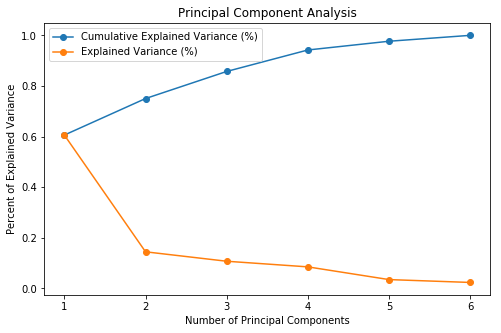

In [5]:
# create instance of PCA class
pca = PCA()
# fit and transform the data and put back into dataframe
data_pca = pd.DataFrame(pca.fit_transform(data_rs), index=data.index)
# rename the columns
data_pca.columns = ['pca{}'.format(i) for i in range(1, 7)]

print(f'Explained Variance:\n\t{pca.explained_variance_ratio_}')
print(f'Cumulative Explained Variance:\n\t{pca.explained_variance_ratio_.cumsum()}')

# create the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# plot the cumulative explained variance ratio
_ = ax.plot(range(1, 7), pca.explained_variance_ratio_.cumsum(), marker='o',
            label='Cumulative Explained Variance (%)')
# plot the explained variance ratio
_ = ax.plot(range(1, 7), pca.explained_variance_ratio_, marker='o',
            label='Explained Variance (%)')
# set axis labels and title
_ = ax.set(xlabel='Number of Principal Components', 
           ylabel='Percent of Explained Variance',
           title='Principal Component Analysis')
# show the legend
_ = ax.legend()

Two principal components explains about 75% of the variance of the dataset. That's pretty good although the number of features (6) is small. 

Just to qualitatively show how the first two principal components captures the variance of each feature, I'll make 6 scatter plots of the first two components and color the points by the values of each feature.

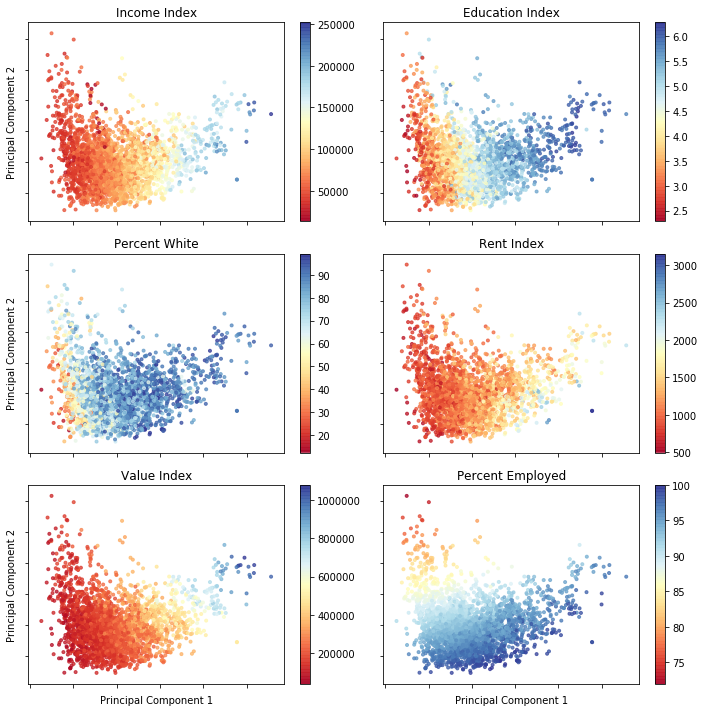

In [6]:
# create figure and 6 subplots, sharing axes for better alignment (probably unnecessary)
fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

# loop through the columns and axes - i is just an axes counter
for i, (col, ax) in enumerate(zip(cols, axes.flatten())):
    # scatter the first two principal components and color by column values
    sc = ax.scatter(data_pca['pca1'], data_pca['pca2'], c=data[col], 
                    marker='.', alpha=0.75, cmap=plt.cm.RdYlBu)
    # set title and turn axis labels off (they don't really mean anything)
    ax.set(title=col, xticklabels=[], yticklabels=[])
    # set the xlabel only on the bottom two subplots
    if i in [4, 5]:
        ax.set(xlabel='Principal Component 1')
    # set the ylabel only on the left three plots
    if i in [0, 2, 4]:
        ax.set(ylabel='Principal Component 2')
    # create a colorbar for each subplot
    fig.colorbar(sc, ax=ax)
# make some room between subplots
fig.tight_layout()

## t-Distributed Stochastic Neighbor Embedding (tSNE)
tSNE is another dimension reduction technique used for visualizing high dimensional data. It models the data in such a way that similar objects are nearby while dissimilar objects are distant.

In [7]:
tsne = TSNE(init='pca')
data_tsne = pd.DataFrame(tsne.fit_transform(data_rs), index=data_rs.index)
data_tsne.columns = ['tsne1', 'tsne2']

Now I'll do the same plot as above except using tSNE instead of PCA

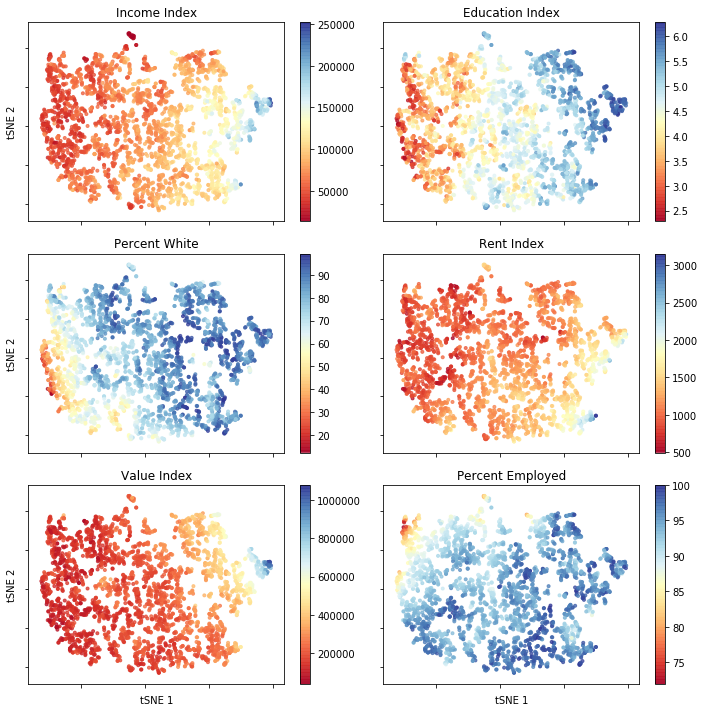

In [12]:
# create figure and 6 subplots, sharing axes for better alignment (probably unnecessary)
fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

# loop through the columns and axes - i is just an axes counter
for i, (col, ax) in enumerate(zip(cols, axes.flatten())):
    # scatter the first two principal components and color by column values
    sc = ax.scatter(data_tsne['tsne1'], data_tsne['tsne2'], c=data[col], 
                    marker='.', alpha=0.75, cmap=plt.cm.RdYlBu)
    # set title and turn axis labels off (they don't really mean anything)
    ax.set(title=col, xticklabels=[], yticklabels=[])
    # set the xlabel only on the bottom two subplots
    if i in [4, 5]:
        ax.set(xlabel='tSNE 1')
    # set the ylabel only on the left three plots
    if i in [0, 2, 4]:
        ax.set(ylabel='tSNE 2')
    # create a colorbar for each subplot
    fig.colorbar(sc, ax=ax)
# make some room between subplots
fig.tight_layout()